In [2]:
from UnifiedMomentumModel import Momentum
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import polars as pl

# Use Latex Fonts
plt.rcParams.update({"text.usetex": True, "font.family": "serif", 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'ytick.major.width': 0.5})

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# load data
df_ABL = pl.read_csv(r'./LES_data/fig6_ABL_data.csv')
df_uniform = pl.read_csv(r'./LES_data/fig6_uniform_data.csv')


In [7]:
# prep plotting 
savefig = False
FIGPATH = Path(r'../fig')
FIGPATH.mkdir(parents=True, exist_ok=True)
unified = Momentum.UnifiedMomentum()
ctp_plot = [0.4, 0.8, 1.2, 1.6, 2.4, 3.2, 4.0, 4.8, 6.4, 8.0, 9.6]  # df_uniform['ctp'].unique()
keys = ['an', 'du', 'dv', 'ct'] 

cmap = plt.get_cmap('viridis')
ctp_min = 0.4  #ctps.min()
ctp_max = 9.6  #ctps.max()

key_labels = dict(
    an='$a_n(\\gamma)$ (-)', 
    du='$\\delta u_0 / u_{\\infty}$ (-)',
    dv='$\\delta v_0 / u_{\\infty}$ (-)', 
    ct='$C_T$ (-)', 
    cp='$C_P$ (-)'
)


All subfigures in one plot: 

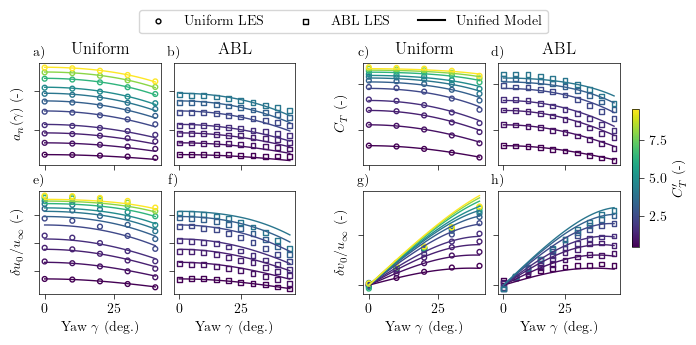

In [9]:
keys = ['an', 'ct', 'du', 'dv']  # new key plotting order

# all in one figure now: 
names = ['Uniform', 'ABL']
ls_list = [dict(marker='o', facecolor='none', s=12), dict(marker='s', facecolor='none', s=12)]

fig, axarr = plt.subplots(2, 6, 
    sharex='col', figsize=(9, 3), width_ratios=[1, 1, 0.12, 0.12, 1, 1], 
    )

# Rearranged order to group terms
order = range(12) # 
order = [0, 6, 4, 10, 1, 7, 2, 8, 5, 11, 3, 9, ]

# Create a new axes array in the rearranged order
new_axes = np.full(axarr.shape, None)

# shuffle figures around to pair them up
for i in range(2):
    for j in range(6):
        new_i, new_j = divmod(order[i*6 + j], 6)
        new_axes[new_i][new_j] = axarr[i, j]

# make pairs share common axes
for (ax1, ax2) in new_axes.T: 
    ax1.sharey(ax2)
    ax2.yaxis.set_ticklabels([])

# hide dummy axes which are for spacing only
for ax in axarr[:, 2:4].ravel(): 
    ax.set_axis_off()

# now actually loop thru and plot the data
for _df, axs, name, _ls in zip([df_uniform, df_ABL], new_axes, names, ls_list):  #df_ABLnw

    df_subset = _df.filter(_df['ctp'].is_in(ctp_plot))
    ctps = df_subset['ctp'].unique()
    yaws = df_subset['yaw'].unique()
    yaw_ax = np.linspace(yaws.min(), yaws.max())
    color = list(cmap((df_subset['ctp'] - ctp_min) / (ctp_max - ctp_min)))

    yaw_ax = np.linspace(yaws.min(), yaws.max())

    # for both dataframes, plot LES data
    for ax, key in zip(axs, keys):
        ax.scatter(df_subset['yaw'], df_subset[key], color=color, **_ls)

        if name == names[0]: 
            ax.set_ylabel(key_labels[key])

    # plot model lines
    for ctp in ctps: 
        ctp_ax = ctp * np.ones_like(yaw_ax)
        sol = unified(ctp_ax, np.deg2rad(yaw_ax))
        ct = sol.Ctprime * (1 - sol.an)**2 * np.cos(sol.yaw)**2
        model = dict(an=sol.an, u4=sol.u4, v4=sol.v4, du=1-sol.u4, dv=-sol.v4, ct=ct)

        for ax, key in zip(axs, keys): 
            ax.plot(yaw_ax, model[key], 
                    color=cmap((ctp-ctp_min)/(ctp_max-ctp_min)), 
                    lw=1., 
                    )
    
    # colorbar
    cmap_d = plt.get_cmap('viridis', len(ctps))
    im = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=ctp_min, vmax=ctp_max))

# plt.tight_layout()
plt.colorbar(im, ax=axarr, label="$C_{T}'$ (-)", shrink=0.6)

plt.subplots_adjust(right=0.77, wspace=0.15, hspace=0.25)

for ax in axarr[-1, :]: 
    ax.set_xlabel('Yaw $\\gamma$ (deg.)')

# some crazy stuff to get the labels correct
for k, ax in enumerate(axarr[0, [0, 1, 4, 5]]):  # titles
    if k % 2: 
        ax.set_title(names[1])
    else: 
        ax.set_title(names[0])

for k, ax in enumerate(axarr[:, [0, 1, 4, 5]].ravel()): 
    ax.text(0, 1.03, f'{chr(k+97)})', ha='center', va='bottom', transform=ax.transAxes)

ax = new_axes[0, 0]
for _ls, name in zip(ls_list, names): 
    ax.scatter([], [], **_ls, label=name + ' LES', color='k')
ax.plot([], color='k', label='Unified Model')

# hand-place this figure
ax.legend(ncols=3, bbox_to_anchor=(2.5, 1.4), loc='center')

if savefig: 
    plt.savefig(FIGPATH / f'nearwake_validation_landscape.pdf')
    plt.savefig(FIGPATH / f'nearwake_validation_landscape.png', dpi=300)

plt.show()


Plot $x_0$: 

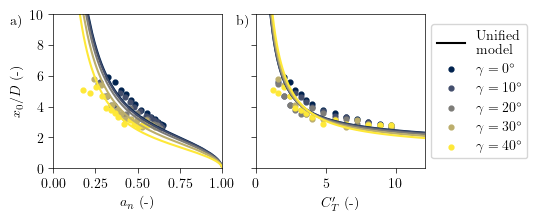

In [10]:
show_range = False
max_x0 = 6.
savefig = True

unified_lower = Momentum.UnifiedMomentum(beta=0.1269)
unified_upper = Momentum.UnifiedMomentum(beta=0.1537)

ctp_ax = np.ctp_ax = np.linspace(0.1, 100, 1000)
ctp_ax = np.hstack([ctp_ax, np.logspace(2.5, 6, 10)])

fig, axs = plt.subplots(figsize=(5.5, 2), ncols=2, sharey=True)
cmap = plt.get_cmap('cividis')
ls = dict(lw=1.5, ls='-')

for ax in axs: 
    # plot this just for the legend element
    ax.plot([], color='k', **ls, label='Unified\n model')

# loop thru yaws and plot as different colors
for yaw in df_uniform['yaw'].unique(): 
    color = cmap((yaw - df_uniform['yaw'].min()) / (df_uniform['yaw'].max() - df_uniform['yaw'].min()))
    _df = df_uniform.filter(pl.col('x0') < max_x0, yaw=yaw)

    axs[0].scatter(
        _df['an'], 
        _df['x0'], 
        color=color, 
        label=f'$\\gamma = {yaw:.0f}^\\circ$', 
        s=12, 
        )
    
    axs[1].scatter(
        _df['ctp'], 
        _df['x0'], 
        color=color, 
        label=f'$\\gamma = {yaw:.0f}^\\circ$', 
        s=12, 
        )


    sol = unified(ctp_ax, np.ones_like(ctp_ax) * np.deg2rad(yaw)) 
    axs[0].plot(sol.an, sol.x0, color=color, **ls)
    axs[1].plot(sol.Ctprime, sol.x0, color=color, **ls)
    if show_range and yaw == 0: 
        sol_lower = unified_lower(ctp_ax, np.ones_like(ctp_ax) * np.deg2rad(yaw)) 
        sol_upper = unified_upper(ctp_ax, np.ones_like(ctp_ax) * np.deg2rad(yaw)) 
        axs[0].fill_between(sol.an, sol_lower.x0, sol_upper.x0, color=color, alpha=0.2)
        axs[1].fill_between(sol.Ctprime, sol_lower.x0, sol_upper.x0, color=color, alpha=0.2)

plt.subplots_adjust(right=0.8, hspace=0.02)
ax = axs[0]
ax.set_ylim([0, 10])
ax.set_ylabel('$x_0/D$ (-)')
ax.set_xlabel('$a_n$ (-)')
ax.set_xlim([0, 1])
# ax.legend(ncols=3, frameon=True, bbox_to_anchor=(0, 1.05), loc='lower left')
ax.text(-0.22, 1, 'a)', ha='center', va='top', transform=ax.transAxes)

ax = axs[1]
ax.set_xlim(0, 12)
ax.set_xticks(range(0, 12, 5))
ax.set_xlabel("$C_T'$ (-)")
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left') 
ax.text(-0.08, 1, 'b)', ha='center', va='top', transform=ax.transAxes)

if savefig: 
    plt.savefig(FIGPATH / 'x0_yaw_uniform_combined.pdf')
    plt.savefig(FIGPATH / 'x0_yaw_uniform_combined.png', dpi=300)
plt.show()
